# Diagnostic Action Sequence Prediction (DAS) Model

This model uses past sequences of diagnostic actions to predict the most likely sequence of future actions. It does not consider the fault or claim history of a vehicle.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, pad_sequences
from datetime import datetime

In [48]:
# Load prepared data
df = pd.read_csv('./data_out/prepared_data.csv', low_memory=False)

In [49]:
# Sort values by 'consultationid' to ensure actions for the same consultation are together
df.sort_values(['consultationid', 'timestamp'], inplace=True)
df['otxsequence'] = df['otxsequence'].astype(str)

# Group by consultationid and join the activities
grouped = df.groupby('consultationid')['otxsequence'].apply(list).reset_index()

# Drop duplicates
grouped = grouped.drop_duplicates('consultationid')
grouped

,consultationid,otxsequence
0,5701,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]"
1,10648,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
2,19643,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
3,21660,"[5, 5, 5, 5, 5]"
4,21868,"[7, 7, 7, 7, 7]"
5,30098,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]"
6,32005,"[12, 12, 12, 12, 12]"
7,33946,"[8, 8, 8, 8, 8]"
8,34540,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
9,36592,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."


In [50]:
# # Create the tokenizer and fit on activity names
# tokenizer = Tokenizer(filters='', lower=False, split=', ')
# tokenizer.fit_on_texts(grouped.otxsequence)
#
# # Convert activity sequences to integers
# sequences = tokenizer.texts_to_sequences(grouped['otxsequence'])
#
# # Save the tokenizer
# with open('models/da_tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

In [51]:
sequences = grouped['otxsequence'].apply(lambda x: list(map(int, x)))

# Compute the average length of the unique actions in each sequence,
# this is the number of actions the model will be predicting
seq_length = int(np.mean([len(set(seq)) for seq in sequences]))

# prepare the sequences
X, y = [], []
for seq in sequences:
    for i in range(seq_length, len(seq)):
        X.append(seq[i-seq_length:i])
        y.append(seq[i:i+seq_length])

# Pad sequences to ensure consistent length
X = pad_sequences(X, maxlen=seq_length, padding='post')
y = pad_sequences(y, maxlen=seq_length, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2023-08-01 21:14:52.837985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-01 21:14:52.840308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-01 21:14:52.841969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1, 64)             896       
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 200)           132000    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 14)            2814      
 tributed)                                                       
                                                                 
Total params: 135,710
Trainable params: 135,710
Non-trainable params: 0
_________________________________________________________________


2023-08-01 21:14:53.257007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-01 21:14:53.321859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-01 21:14:53.326098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

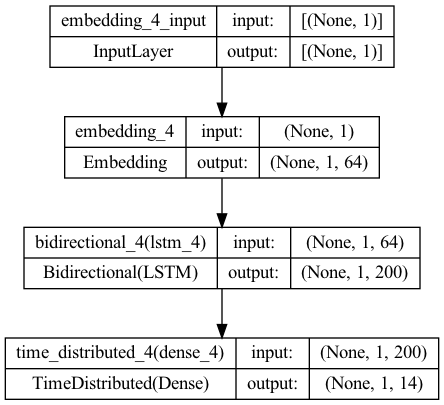

In [52]:
num_activities = df['otxsequence'].nunique()

model = Sequential()
model.add(Embedding(input_dim=num_activities+1, output_dim=64, input_length=seq_length))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dense(num_activities+1, activation='softmax')))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()
plot_model(model, to_file='fixtures/models/das_layers.png', show_shapes=True, show_layer_names=True)

In [53]:
%%time
early_stopping_monitor = EarlyStopping(
    monitor='accuracy',
    min_delta=0.001,  # minimum change to qualify as an improvement
    patience=5,  # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    np.expand_dims(y_train, -1),
    epochs=50,
    validation_data=(X_test, np.expand_dims(y_test, -1)),
    callbacks=[early_stopping_monitor])

Epoch 1/50


2023-08-01 21:14:55.253164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-01 21:14:55.255182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-01 21:14:55.257120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/11 [=>............................] - ETA: 37s - loss: 2.6386 - accuracy: 0.0938

2023-08-01 21:14:59.087835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-01 21:14:59.089723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-01 21:14:59.091337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 5s 98ms/step - loss: 2.6028 - accuracy: 0.6974 - val_loss: 2.5585 - val_accuracy: 0.8391
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 2.5047 - accuracy: 0.8012 - val_loss: 2.4375 - val_accuracy: 0.7241
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 2.3391 - accuracy: 0.7723 - val_loss: 2.2315 - val_accuracy: 0.7241
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 2.0614 - accuracy: 0.7723 - val_loss: 1.8914 - val_accuracy: 0.7241
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 1.6413 - accuracy: 0.7723 - val_loss: 1.4185 - val_accuracy: 0.7241
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 1.1435 - accuracy: 0.7723 - val_loss: 0.9892 - val_accuracy: 0.7241
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.7702 - accuracy: 0.7723 - val_loss: 0.7363 - val_accuracy: 0.7471
Epoch 7: early stopping
CPU ti

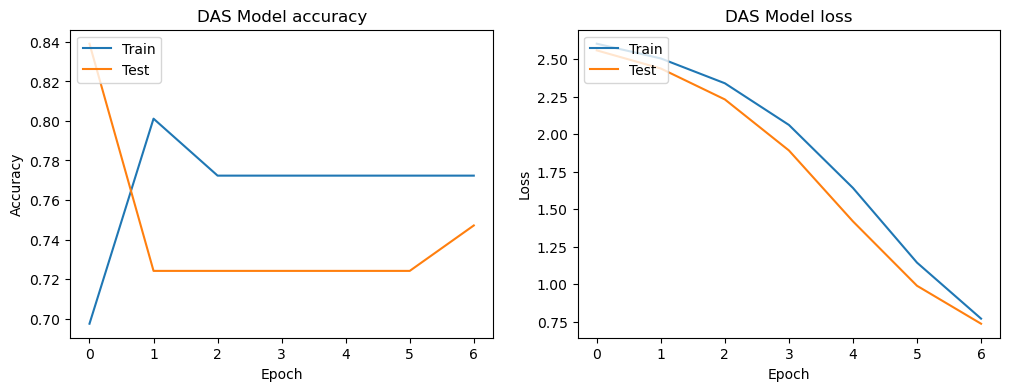

In [54]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DAS Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DAS Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [55]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, np.expand_dims(y_test, -1))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 [==============================] - 0s 3ms/step - loss: 2.4375 - accuracy: 0.7241
Test Loss: 2.437525749206543
Test Accuracy: 0.7241379022598267


This will save the architecture of the model, the weights of the model, the training configuration (loss, optimizer), and the state of the optimizer, allowing us to resume training exactly where we left off.

In [57]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f'fixtures/models/das_{timestamp}.h5')